In [1]:
# unzip dataset_letras.zip
!unzip dataset_numeros_final.zip

Streaming output truncated to the last 5000 lines.
 extracting: dataset_numeros3/0/0_106.png  
 extracting: dataset_numeros3/0/0_107.png  
 extracting: dataset_numeros3/0/0_108.png  
 extracting: dataset_numeros3/0/0_109.png  
 extracting: dataset_numeros3/0/0_11.png  
 extracting: dataset_numeros3/0/0_110.png  
 extracting: dataset_numeros3/0/0_111.png  
 extracting: dataset_numeros3/0/0_112.png  
 extracting: dataset_numeros3/0/0_113.png  
 extracting: dataset_numeros3/0/0_114.png  
 extracting: dataset_numeros3/0/0_115.png  
 extracting: dataset_numeros3/0/0_116.png  
 extracting: dataset_numeros3/0/0_117.png  
 extracting: dataset_numeros3/0/0_118.png  
 extracting: dataset_numeros3/0/0_119.png  
 extracting: dataset_numeros3/0/0_12.png  
 extracting: dataset_numeros3/0/0_120.png  
 extracting: dataset_numeros3/0/0_121.png  
 extracting: dataset_numeros3/0/0_122.png  
 extracting: dataset_numeros3/0/0_123.png  
 extracting: dataset_numeros3/0/0_124.png  
 extracting: dataset_numero

In [2]:
!pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.0/311.0 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.7 MB/s eta 0:00:00


In [3]:
import wandb

## Login
wandb.login(key='a14c6a2ec25620e6e2047f787c8dbe5d7710eaef')

## Inicializa WandB
wandb.init(project="repte1_psiv", entity="andreu-mir")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: andreu-mir. Use `wandb login --relogin` to force relogin


# 1. Arquitectura model

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FCNModel(nn.Module):
    def __init__(self):
        super(FCNModel, self).__init__()

        # Aplanar imágenes 1x64x40 a un vector de 2560 elementos (64*40)
        self.fc1 = nn.Linear(1 * 64 * 40, 512)  # Primera capa totalmente conectada
        self.fc2 = nn.Linear(512, 128)          # Segunda capa
        self.fc3 = nn.Linear(128, 26)           # Capa de salida para 26 clases
        self.dropout = nn.Dropout(0.5)          # Dropout para regularización

    def forward(self, x):
        x = x.view(-1, 1 * 64 * 40)             # Aplanar las imágenes (batch_size, 1*64*40)
        x = F.relu(self.fc1(x))                 # Capa oculta 1 con ReLU
        x = self.dropout(x)                     # Aplicar dropout
        x = F.relu(self.fc2(x))                 # Capa oculta 2 con ReLU
        x = self.fc3(x)                         # Capa de salida
        return x

# Crear una instancia del modelo
model = FCNModel()


# 2. Dataset

In [12]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.model_selection import KFold
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import wandb
import seaborn as sns
import matplotlib.pyplot as plt

# Inicializar WandB
wandb.init(project="number_recognition_fcn")

# Definición de parámetros
batch_size = 32
img_height, img_width = 64, 40  # Tamaño de las imágenes

# Transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((img_height, img_width)),  # Redimensionar las imágenes
    transforms.Grayscale(num_output_channels=1),  # Asegurarse de que la imagen sea en escala de grises
    transforms.ToTensor(),  # Convertir imágenes a tensores
    transforms.Normalize((0.5,), (0.5,)),  # Normalizar las imágenes (grayscale)
])

# Cargar el dataset
base_dir = 'dataset_numeros3'
dataset = datasets.ImageFolder(root=base_dir, transform=transform)

# Número de pliegues para la validación cruzada
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)

# Verificación
print(f"Total dataset size: {len(dataset)}")

wandb: Currently logged in as: andreu-mir (xisca). Use `wandb login --relogin` to force relogin


Total dataset size: 5000


# 3. Train Model

In [13]:
import torch.nn as nn
import torch.optim as optim

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
# see shape of dataset_letras\0\0_0.png

print(dataset[0][0].shape)

torch.Size([1, 64, 40])


Fold 1/5
Epoch [1/20], Loss: 0.6849, Accuracy: 0.7933
Epoch [2/20], Loss: 0.3873, Accuracy: 0.8695
Epoch [3/20], Loss: 0.3566, Accuracy: 0.8792
Epoch [4/20], Loss: 0.3479, Accuracy: 0.8750
Epoch [5/20], Loss: 0.3298, Accuracy: 0.8820
Epoch [6/20], Loss: 0.3110, Accuracy: 0.8888
Epoch [7/20], Loss: 0.2971, Accuracy: 0.8965
Epoch [8/20], Loss: 0.2921, Accuracy: 0.8968
Epoch [9/20], Loss: 0.2857, Accuracy: 0.9005
Epoch [10/20], Loss: 0.2664, Accuracy: 0.9005
Epoch [11/20], Loss: 0.2679, Accuracy: 0.9035
Epoch [12/20], Loss: 0.2557, Accuracy: 0.9097
Epoch [13/20], Loss: 0.2580, Accuracy: 0.9100
Epoch [14/20], Loss: 0.2542, Accuracy: 0.9093
Epoch [15/20], Loss: 0.2385, Accuracy: 0.9120
Epoch [16/20], Loss: 0.2376, Accuracy: 0.9195
Epoch [17/20], Loss: 0.2431, Accuracy: 0.9110
Epoch [18/20], Loss: 0.2314, Accuracy: 0.9140
Epoch [19/20], Loss: 0.2218, Accuracy: 0.9203
Epoch [20/20], Loss: 0.2191, Accuracy: 0.9243
Validation Loss: 0.2475, Validation Accuracy: 0.9120
Validation Precision: 0.915

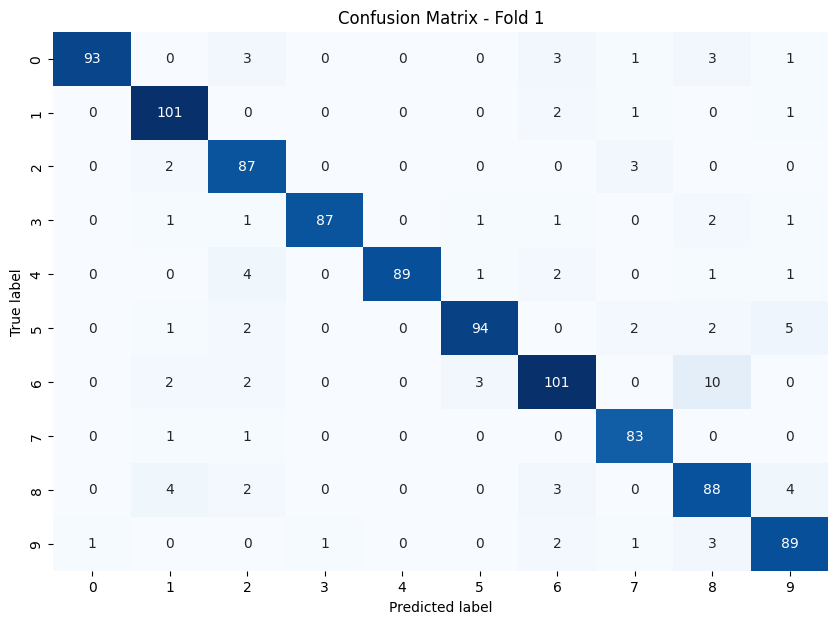

Fold 2/5
Epoch [1/20], Loss: 0.2538, Accuracy: 0.9100
Epoch [2/20], Loss: 0.2302, Accuracy: 0.9203
Epoch [3/20], Loss: 0.2155, Accuracy: 0.9187
Epoch [4/20], Loss: 0.2112, Accuracy: 0.9245
Epoch [5/20], Loss: 0.1995, Accuracy: 0.9273
Epoch [6/20], Loss: 0.1911, Accuracy: 0.9323
Epoch [7/20], Loss: 0.2084, Accuracy: 0.9280
Epoch [8/20], Loss: 0.1967, Accuracy: 0.9335
Epoch [9/20], Loss: 0.1814, Accuracy: 0.9353
Epoch [10/20], Loss: 0.1884, Accuracy: 0.9350
Epoch [11/20], Loss: 0.1901, Accuracy: 0.9305
Epoch [12/20], Loss: 0.1732, Accuracy: 0.9375
Epoch [13/20], Loss: 0.1803, Accuracy: 0.9390
Epoch [14/20], Loss: 0.1726, Accuracy: 0.9393
Epoch [15/20], Loss: 0.1758, Accuracy: 0.9347
Epoch [16/20], Loss: 0.1708, Accuracy: 0.9395
Epoch [17/20], Loss: 0.1700, Accuracy: 0.9400
Epoch [18/20], Loss: 0.1724, Accuracy: 0.9390
Epoch [19/20], Loss: 0.1729, Accuracy: 0.9375
Epoch [20/20], Loss: 0.1874, Accuracy: 0.9375
Validation Loss: 0.1954, Validation Accuracy: 0.9380
Validation Precision: 0.939

<Figure size 640x480 with 0 Axes>

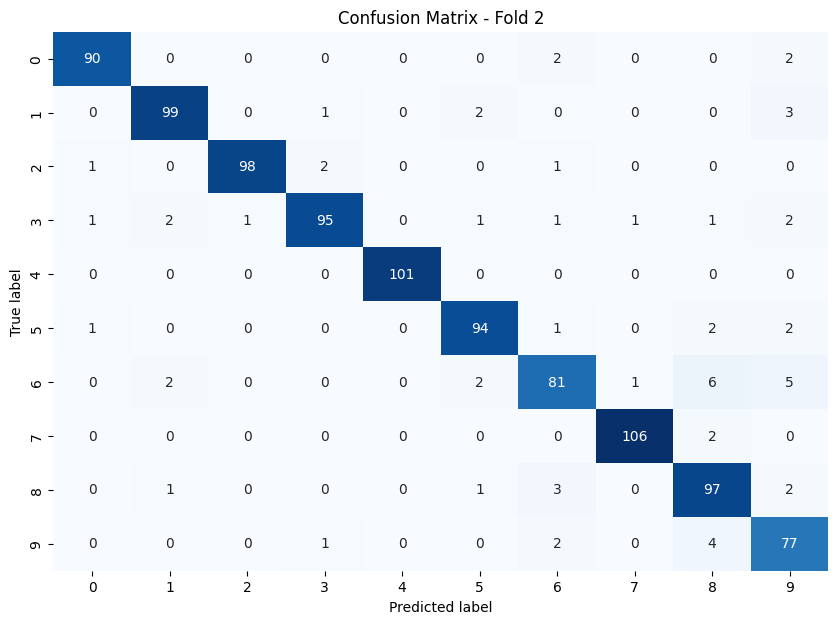

Fold 3/5
Epoch [1/20], Loss: 0.1946, Accuracy: 0.9327
Epoch [2/20], Loss: 0.1812, Accuracy: 0.9365
Epoch [3/20], Loss: 0.1757, Accuracy: 0.9380
Epoch [4/20], Loss: 0.1799, Accuracy: 0.9347
Epoch [5/20], Loss: 0.1678, Accuracy: 0.9387
Epoch [6/20], Loss: 0.1580, Accuracy: 0.9435
Epoch [7/20], Loss: 0.1649, Accuracy: 0.9425
Epoch [8/20], Loss: 0.1739, Accuracy: 0.9403
Epoch [9/20], Loss: 0.1689, Accuracy: 0.9400
Epoch [10/20], Loss: 0.1847, Accuracy: 0.9400
Epoch [11/20], Loss: 0.1501, Accuracy: 0.9475
Epoch [12/20], Loss: 0.1539, Accuracy: 0.9465
Epoch [13/20], Loss: 0.1570, Accuracy: 0.9423
Epoch [14/20], Loss: 0.1587, Accuracy: 0.9445
Epoch [15/20], Loss: 0.1426, Accuracy: 0.9503
Epoch [16/20], Loss: 0.1475, Accuracy: 0.9493
Epoch [17/20], Loss: 0.1421, Accuracy: 0.9493
Epoch [18/20], Loss: 0.1427, Accuracy: 0.9515
Epoch [19/20], Loss: 0.1449, Accuracy: 0.9473
Epoch [20/20], Loss: 0.1599, Accuracy: 0.9457
Validation Loss: 0.1310, Validation Accuracy: 0.9540
Validation Precision: 0.955

<Figure size 640x480 with 0 Axes>

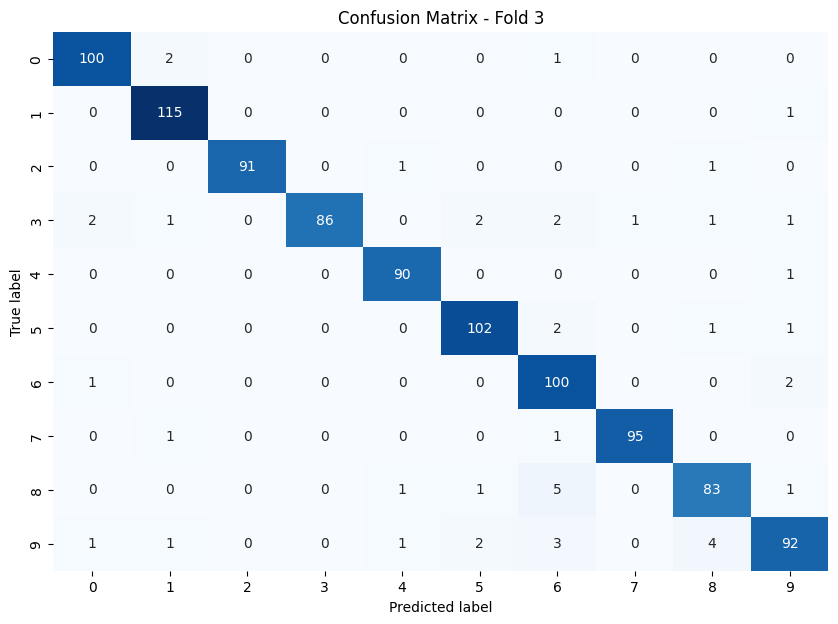

Fold 4/5
Epoch [1/20], Loss: 0.1516, Accuracy: 0.9460
Epoch [2/20], Loss: 0.1559, Accuracy: 0.9430
Epoch [3/20], Loss: 0.1461, Accuracy: 0.9517
Epoch [4/20], Loss: 0.1400, Accuracy: 0.9507
Epoch [5/20], Loss: 0.1358, Accuracy: 0.9495
Epoch [6/20], Loss: 0.1262, Accuracy: 0.9565
Epoch [7/20], Loss: 0.1420, Accuracy: 0.9503
Epoch [8/20], Loss: 0.1378, Accuracy: 0.9487
Epoch [9/20], Loss: 0.1494, Accuracy: 0.9517
Epoch [10/20], Loss: 0.1431, Accuracy: 0.9520
Epoch [11/20], Loss: 0.1347, Accuracy: 0.9537
Epoch [12/20], Loss: 0.1377, Accuracy: 0.9530
Epoch [13/20], Loss: 0.1274, Accuracy: 0.9547
Epoch [14/20], Loss: 0.1402, Accuracy: 0.9500
Epoch [15/20], Loss: 0.1241, Accuracy: 0.9555
Epoch [16/20], Loss: 0.1406, Accuracy: 0.9520
Epoch [17/20], Loss: 0.1214, Accuracy: 0.9560
Epoch [18/20], Loss: 0.1389, Accuracy: 0.9537
Epoch [19/20], Loss: 0.1291, Accuracy: 0.9577
Epoch [20/20], Loss: 0.1266, Accuracy: 0.9560
Validation Loss: 0.0978, Validation Accuracy: 0.9640
Validation Precision: 0.965

<Figure size 640x480 with 0 Axes>

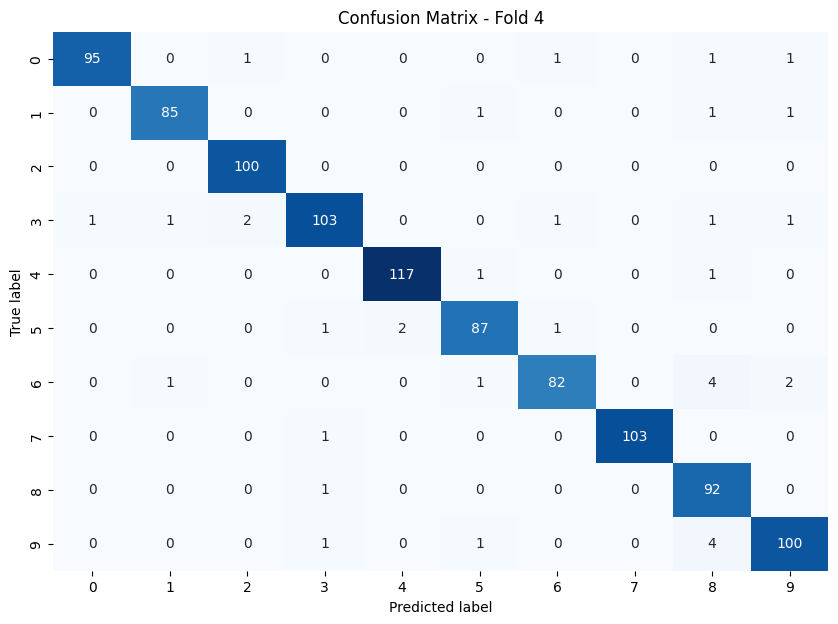

Fold 5/5
Epoch [1/20], Loss: 0.1423, Accuracy: 0.9507
Epoch [2/20], Loss: 0.1450, Accuracy: 0.9523
Epoch [3/20], Loss: 0.1444, Accuracy: 0.9527
Epoch [4/20], Loss: 0.1557, Accuracy: 0.9483
Epoch [5/20], Loss: 0.1436, Accuracy: 0.9503
Epoch [6/20], Loss: 0.1416, Accuracy: 0.9523
Epoch [7/20], Loss: 0.1332, Accuracy: 0.9527
Epoch [8/20], Loss: 0.1238, Accuracy: 0.9557
Epoch [9/20], Loss: 0.1389, Accuracy: 0.9545
Epoch [10/20], Loss: 0.1179, Accuracy: 0.9605
Epoch [11/20], Loss: 0.1264, Accuracy: 0.9570
Epoch [12/20], Loss: 0.1202, Accuracy: 0.9590
Epoch [13/20], Loss: 0.1340, Accuracy: 0.9563
Epoch [14/20], Loss: 0.1229, Accuracy: 0.9567
Epoch [15/20], Loss: 0.1281, Accuracy: 0.9537
Epoch [16/20], Loss: 0.1240, Accuracy: 0.9583
Epoch [17/20], Loss: 0.1287, Accuracy: 0.9537
Epoch [18/20], Loss: 0.1014, Accuracy: 0.9650
Epoch [19/20], Loss: 0.1091, Accuracy: 0.9653
Epoch [20/20], Loss: 0.1132, Accuracy: 0.9565
Validation Loss: 0.1040, Validation Accuracy: 0.9670
Validation Precision: 0.967

<Figure size 640x480 with 0 Axes>

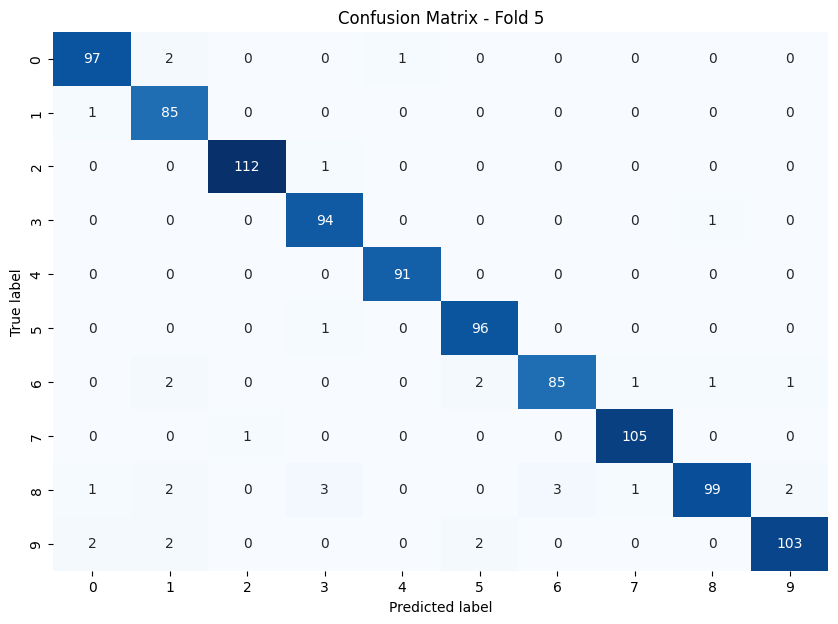

<Figure size 640x480 with 0 Axes>

In [15]:
# Loop a través de los pliegues
for fold, (train_indices, val_indices) in enumerate(kfold.split(range(len(dataset)))):
    print(f'Fold {fold + 1}/{num_folds}')

    # Crear subconjuntos de entrenamiento y validación
    train_subset = Subset(dataset, train_indices)
    val_subset = Subset(dataset, val_indices)

    # Crear DataLoaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Mover el modelo a la GPU
    model.to('cuda')

    train_losses = []
    train_accuracies = []

    num_epochs = 20
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to('cuda')  # Usa 'cuda' si tienes GPU
            labels = labels.to('cuda')  # Usa 'cuda' si tienes GPU

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calcular precisión
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calcula y registra la pérdida y la precisión
        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct / total

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # Log metrics to WandB
        wandb.log({
            "epoch": epoch + 1,
            "loss": epoch_loss,
            "accuracy": epoch_accuracy,
        })

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

    # Validación
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    val_labels = []
    val_predictions = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to('cuda')
            labels = labels.to('cuda')

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            # Calcular precisión
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            val_labels.extend(labels.cpu().numpy())
            val_predictions.extend(predicted.cpu().numpy())

    # Calcula y muestra la pérdida y precisión de validación
    val_epoch_loss = val_running_loss / len(val_loader)
    val_epoch_accuracy = val_correct / val_total

    # Calcular métricas adicionales
    precision = precision_score(val_labels, val_predictions, average='weighted')
    recall = recall_score(val_labels, val_predictions, average='weighted')
    f1 = f1_score(val_labels, val_predictions, average='weighted')
    cm = confusion_matrix(val_labels, val_predictions)

    # Log métricas de validación a WandB
    wandb.log({
        "fold": fold + 1,
        "val_loss": val_epoch_loss,
        "val_accuracy": val_epoch_accuracy,
        "val_precision": precision,
        "val_recall": recall,
        "val_f1": f1,
    })

    # Imprimir métricas
    print(f'Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.4f}')
    print(f'Validation Precision: {precision:.4f}')
    print(f'Validation Recall: {recall:.4f}')
    print(f'Validation F1 Score: {f1:.4f}')
    print('Confusion Matrix:')
    print(cm)

    # Visualizar la matriz de confusión
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.title(f'Confusion Matrix - Fold {fold + 1}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Guardar la figura
    wandb.log({"confusion_matrix": wandb.Image(plt)})
    plt.show()
    plt.clf()  # Limpiar la figura para la próxima iteración




In [16]:
# Finaliza la sesión de WandB
wandb.finish()

accuracy,▁▂▂▃▃▄▃▄▄▅▅▆▆▆▆▆▆▇▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇█
epoch,▂▂▃▃▄▆▇▇█▁▃▄▄▅▆▇█▁▂▃▄▅▇█▁▂▂▅▇█▂▃▄▅▅▆▇▇▇█
fold,▁▃▅▆█
loss,█▇▅▄▄▄▄▃▃▃▃▃▃▂▂▃▂▂▂▂▂▁▂▂▂▂▁▁▂▂▂▂▂▂▁▂▁▁▁▁
val_accuracy,▁▄▆██
val_f1,▁▄▆██
val_loss,█▆▃▁▁
val_precision,▁▄▆██
val_recall,▁▄▆██
accuracy,0.9565
epoch,20


In [17]:
model_save_path = f'model_number_classifier_fcn.pth'
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

Model saved to model_number_classifier_fcn.pth
